In [1]:
import os
gpu_num = 0 # 使用 "" 来启用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
import matplotlib.pyplot as plt
import numpy as np
import sionna

# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from mysionna.rt.scattering_pattern import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
scene = load_scene("Indoor/indoor.xml")
# scene = load_scene(sionna.rt.scene.etoile)

In [3]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

In [4]:
# ################创建发射机#########################
# tx = Transmitter(name="tx",
#                  position=[0,-4.95,2.95])
# ################ 将发射机加入到场景中##############
# scene.add(tx)
# #################创建接收机########################
# rx = Receiver(name="rx",
#               position=[0,-4.95,2.95])
# ################ 将接收机加入到场景中##############
# scene.add(rx)
# tx.look_at([0,0,0])
# rx.look_at([0,0,0])

In [5]:
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [6]:
scene.target_names = ["human"]
scene.target_velocities = [(-1.2,-0.4,0.)]

In [7]:
p1 = LambertianPattern()
p2 = DirectivePattern(20)
scene.get("itu_plywood").scattering_coefficient = 0.4
scene.get("itu_plywood").scattering_pattern = p2
scene.get("itu_concrete").scattering_coefficient = 0.3
scene.get("itu_concrete").scattering_pattern = p1
scene.get("itu_floorboard").scattering_coefficient = 0.4
scene.get("itu_floorboard").scattering_pattern = p2
scene.get("itu_ceiling_board").scattering_coefficient = 0.4
scene.get("itu_ceiling_board").scattering_pattern = p2
scene.get("itu_metal").scattering_coefficient = 0.7
scene.get("itu_metal").scattering_pattern = p1

In [8]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [9]:
# # compute cell positions
# cell_num_x = int(map_size_x/cell_size) + 1 # Number of x cells in the map
# cell_num_y = int(map_size_y/cell_size) + 1 # Number of y cells in the map
# cell_positions = np.zeros((cell_num_x, cell_num_y, 3))
# # fill x
# x_fill = np.arange(0,cell_num_x) * cell_size + map_center[0] - map_size_x/2
# x_fill = np.tile(x_fill,cell_num_y)
# cell_positions[:,:,0] = x_fill.reshape([cell_num_y,cell_num_x]).transpose()
# # fill y
# y_fill = np.arange(0,cell_num_y) * cell_size + map_center[1] - map_size_y/2
# y_fill = np.tile(y_fill,cell_num_x)
# cell_positions[:,:,1] = y_fill.reshape([cell_num_x,cell_num_y])
# # fill z
# cell_positions[:,:,2] = np.tile(map_center[2],(cell_num_x,cell_num_y))
# cell_pos = tf.constant(cell_positions, dtype=tf.float32)
# # [num_cells_x*num_cells_y, 3]
# cell_pos = tf.reshape(cell_pos, [-1, 3])  

In [10]:
crbs = scene.coverage_map_sensing(map_center=[0,0,2.95],
                                  map_size_x=6,
                                  map_size_y=10,
                                  cell_size=0.5,
                                  look_at=[1.9,2.7,1.0],
                                  batch_size=100,
                                  num_samples=100000,
                                  num_time_steps=1)

In [12]:
crb = None
for i in range(0,len(crbs)):
    c = crbs[i][0]
    c = tf.squeeze(c)
    c = c.numpy()
    if crb is None:
        crb = c
    else:
        crb = np.concatenate((crb,c),axis=None)
crb = np.array(crb)

In [13]:
crb = np.reshape(crb,[-1,21])

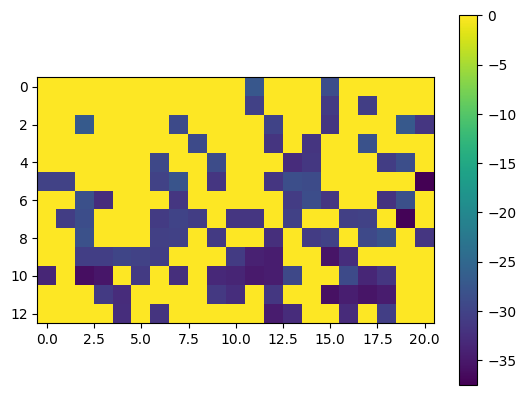

In [14]:
crb = np.log10(crb)
plt.imshow(crb)
plt.colorbar()

In [8]:
paths = scene.compute_paths(max_depth=4,diffraction=True,scattering=True,edge_diffraction=True)

In [ ]:
# scene.preview(paths=paths)

In [9]:
v,obj=scene.compute_target_velocities(paths, return_obj_names=True)

In [10]:
subcarrier_spacing = 15e3
num_time_steps = 1
paths.apply_doppler(sampling_frequency=subcarrier_spacing, num_time_steps=num_time_steps,target_velocities=v)

In [11]:
crb = paths.crb_delay()

In [12]:
paths.export_crb(crb,"test.xyzrgb")

True